# Dogs vs Cats Redux - Kaggle Pre Built ResNet()

In this notebook, we will explore how we can use a pre-trained Resnet network to classify images as either dogs or cats. We will then submit our predictions to this kaggle competition:

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

Here is a list of models tried in this notebook : 
    - Prebuilt Resnet With Fully Connected Layer on Top
    - Prebuilt Resnet Ensemble of Fully Connected Layer on Top
    - Prebuilt Resnet With Fully Connected Convolution(FCC) Layers - No Dense Layers
    - Prebuild Resnet With Larger Image Size, Data Augmentation and FCC Layers

## Imports

In [1]:
from importlib import reload
from PIL import Image
import gc

In [28]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import numpy as np

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Input, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K

np.random.seed(7)

In [3]:
from __future__ import division,print_function

import bcolz
from IPython.display import FileLink
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

## Directory structure of the data

In Keras, for image recognition/classification, we need to arrange the data in a certain structure (i.e, if we suethe flow_from_directory method of ImageDataGenerator). Images from each category for training must be placed in a separate folder. 

Here, we have two separate folders 'cats' and 'dogs' each of which contains training examples belonging to that class. We do the same for validation set. 

Since the test set examples are unlabeled (as we are to predict them), we put all those examples into an 'unknown' folder.

NOTE : This fixed directory structure was created from the command line and this code for it is not present in this notebook. Code for directory structure creation will be added to future notebooks

In [4]:
PATH = 'data/dogscatsredux/'
MODEL_PATH = PATH + 'models/'
TRAIN_PATH = PATH + 'train/'
VALID_PATH = PATH + 'valid/'
TEST_PATH = PATH + 'test/'
RESULT_PATH = PATH + 'results/'

In [5]:
% ls 'data/dogscatsredux/'

models/  results/  sample/  sample_submission.csv  test/  train/  valid/


In [6]:
% ls 'data/dogscatsredux/test'

unknown/


In [7]:
% ls 'data/dogscatsredux/train'

cats/  dogs/


In [8]:
% ls 'data/dogscatsredux/valid'

cats/  dogs/


Let us now see a few of these images

In [9]:
%ls -U 'data/dogscatsredux/train/cats' | head -4

cat.8760.jpg
cat.710.jpg
cat.1069.jpg
cat.11298.jpg
ls: write error


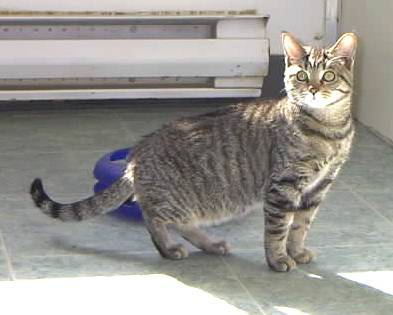

In [10]:
ex_path = TRAIN_PATH+'cats/'
Image.open(ex_path + 'cat.8760.jpg')

As we can see, the directory structure is in the format needed by keras

## Load ResNet Model

In the cell below, I am forcing Keras to use the 'channels_last' image data format since my backend is tensorflow. This would be set to 'channels_first' for Theano backend

In [11]:
K.set_image_data_format("channels_last")

In [12]:
img_height, img_weidth = 224,224

One of the cool things about Keras is that it has deep learning models that are made available alongside pre-trained weights. These models are the ones which have won ImageNet over the years.

Another convivient option given by these Keras application APIs' is whether to include the fully connected dense layersm present at the top of the model, or not. 

We are not including those layers since we want to finetune our model to the Dogs vs Cats task.

Reference : https://keras.io/applications/

In [13]:
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape=(img_height,img_weidth,3))


In [14]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Save output of base model

We have imported the vgg16 model's preprocess_input method. This we are passing as an argument to the ImageDataGenerator since we want the input to be pre-processed VGG16 style.

In [15]:
gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 64

**IMPORTANT NOTE**

In this case, shuffle *needs* to be False since we want to extract the labels in the order that they are predicted

In [16]:
train_batches = gen.flow_from_directory(directory=TRAIN_PATH,target_size=(img_weidth,img_height),\
                                        class_mode='categorical',batch_size=batch_size,\
                                        shuffle=False)

Found 20000 images belonging to 2 classes.


In [17]:
valid_batches = gen.flow_from_directory(directory=VALID_PATH,target_size=(img_weidth,img_height),\
                                        class_mode='categorical',batch_size=batch_size,\
                                        shuffle=False)

Found 5000 images belonging to 2 classes.


In [18]:
test_batches = gen.flow_from_directory(directory=TEST_PATH,target_size=(img_weidth,img_height),\
                                        class_mode='categorical',batch_size=batch_size,\
                                        shuffle=False)

Found 12500 images belonging to 1 classes.


In [19]:
valid_classes = valid_batches.classes
train_classes = train_batches.classes

#We need to convert the labels into one-hot-encoded form since the loss function is 'categorical_crossentropy'
valid_labels = to_categorical(valid_classes)
train_labels = to_categorical(train_classes)

**IMPORANT NOTE** : **Saving output of base model**

We're going to be training a number of iterations for a bunch of differerent fully connected layers. 

So it would be best for us to pre-calculate the output of our base model (and thus all its convolution layers) which will then be fed as input to the fully connected layers (which we will be adding later on top of our base model). 

This will help us save time since our computation would have to go through the base model only once. (This computation would be the same for every different model we add on top of our base model.) Hence it makes sense to store the output of the base model.

The other alternative to this was to just add our fully connected layer model on top of the base model itself. Then set the base model layers to not be trainable and just train the newly added dense layers. However this would be computationally inefficient since our calculations would go again and again through the base model layers too.

In [20]:
train_steps = int(np.ceil(train_batches.n/batch_size))
validation_steps = int(np.ceil(valid_batches.n/batch_size))
test_steps = int(np.ceil(test_batches.n/batch_size))

In [21]:
valid_features_to_dense = base_model.predict_generator(valid_batches, validation_steps, verbose=1)

79/79 [==============================] - 50s 628ms/step


In [22]:
train_features_to_dense = base_model.predict_generator(train_batches, train_steps, verbose=1)

313/313 [==============================] - 189s 605ms/step


In [23]:
test_features_to_dense = base_model.predict_generator(test_batches, test_steps, verbose=1)

196/196 [==============================] - 119s 605ms/step


We can save these arrays to a file so that we can simply load them up the next time we run the notebook and save time.

In [23]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()


def load_array(fname):
    return bcolz.open(fname)[:]

In [25]:
save_array(MODEL_PATH + 'train_res_maxpool_layer_features.bc', train_features_to_dense)
save_array(MODEL_PATH + 'train_res_maxpool_layer_labels.bc', train_labels)

save_array(MODEL_PATH + 'valid_res_maxpool_layer_features.bc', valid_features_to_dense)
save_array(MODEL_PATH + 'valid_res_maxpool_layer_labels.bc', valid_labels)

In [26]:
save_array(MODEL_PATH + 'test_res_maxpool_layer_features.bc', test_features_to_dense)

In [24]:
train_features_to_dense = load_array(MODEL_PATH+'train_res_maxpool_layer_features.bc')
train_labels = load_array(MODEL_PATH+'train_res_maxpool_layer_labels.bc')

valid_features_to_dense = load_array(MODEL_PATH+'valid_res_maxpool_layer_features.bc')
valid_labels = load_array(MODEL_PATH+'valid_res_maxpool_layer_labels.bc')

In [25]:
test_features_to_dense = load_array(MODEL_PATH + 'test_res_maxpool_layer_features.bc')

In [26]:
gc.collect()

62008

## Add fully connected layer to top of base model

Now that we have the output of our base model, we can add the fully connected (fc) layer model on top of that.

The model we are adding below is exactly same as ResNet except for the fact that the last dense layer has 2 outputs instead of 1000 as was the case with ResNet

In [40]:
def fc_model():
    inp = Input(shape=base_model.output_shape[1:])
    x = Flatten()(inp)
    predictions = Dense(2, activation = 'softmax')(x)

    new_model = Model(inp, predictions)
    new_model.compile(optimizer=RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    return new_model

In [41]:
new_model = fc_model()
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4098      
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


In [42]:
new_model.optimizer.lr = 1e-3
new_model.fit(train_features_to_dense, train_labels, epochs=10, 
             batch_size=batch_size*4, validation_data=(valid_features_to_dense, valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 34us/step - loss: 0.1337 - acc: 0.9484 - val_loss: 0.0434 - val_acc: 0.9840
Epoch 2/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0387 - acc: 0.9860 - val_loss: 0.0326 - val_acc: 0.9872
Epoch 3/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0310 - acc: 0.9892 - val_loss: 0.0318 - val_acc: 0.9870
Epoch 4/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0285 - acc: 0.9899 - val_loss: 0.0517 - val_acc: 0.9834
Epoch 5/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0242 - acc: 0.9914 - val_loss: 0.0318 - val_acc: 0.9874
Epoch 6/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0225 - acc: 0.9920 - val_loss: 0.0319 - val_acc: 0.9878
Epoch 7/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0214 - acc: 0.9926 - val_loss: 0.0323 - val_acc:

Since we just have a single dense layer with 2 units ( and we have precomputed outputs of the previous convolution layers), the training is super fast.
Running for a few more epochs ...

In [43]:
new_model.optimizer.lr = 1e-6
new_model.fit(train_features_to_dense, train_labels, epochs=15, 
             batch_size=batch_size*4, validation_data=(valid_features_to_dense, valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0175 - acc: 0.9942 - val_loss: 0.0342 - val_acc: 0.9878
Epoch 2/15
20000/20000 [==============================] - 0s 18us/step - loss: 0.0149 - acc: 0.9956 - val_loss: 0.0437 - val_acc: 0.9840
Epoch 3/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0151 - acc: 0.9955 - val_loss: 0.0438 - val_acc: 0.9870
Epoch 4/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0135 - acc: 0.9959 - val_loss: 0.0493 - val_acc: 0.9864
Epoch 5/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0131 - acc: 0.9959 - val_loss: 0.0395 - val_acc: 0.9848
Epoch 6/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0124 - acc: 0.9964 - val_loss: 0.0349 - val_acc: 0.9878
Epoch 7/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0120 - acc: 0.9963 - val_loss: 0.0368 - val_acc:

## ResNet Ensemble

Lets create an ensemble to get a further boost to our predictions

In [53]:
def fit_single_model():
    new_model = fc_model()
    
    new_model.optimizer.lr = 1e-3
    new_model.fit(train_features_to_dense, train_labels, epochs=10, 
             batch_size=batch_size*4, validation_data=(valid_features_to_dense, valid_labels))

    new_model.optimizer.lr = 1e-6
    new_model.fit(train_features_to_dense, train_labels, epochs=15, 
             batch_size=batch_size*4, validation_data=(valid_features_to_dense, valid_labels))
    
    return new_model

In [54]:
ensemble_model = [fit_single_model() for i in range(10)]

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 36us/step - loss: 0.1541 - acc: 0.9442 - val_loss: 0.0435 - val_acc: 0.9858
Epoch 2/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0378 - acc: 0.9869 - val_loss: 0.0449 - val_acc: 0.9818
Epoch 3/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0306 - acc: 0.9895 - val_loss: 0.0312 - val_acc: 0.9874
Epoch 4/10
20000/20000 [==============================] - 0s 20us/step - loss: 0.0278 - acc: 0.9906 - val_loss: 0.0315 - val_acc: 0.9876
Epoch 5/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0242 - acc: 0.9917 - val_loss: 0.0334 - val_acc: 0.9880
Epoch 6/10
20000/20000 [==============================] - 0s 18us/step - loss: 0.0220 - acc: 0.9922 - val_loss: 0.0456 - val_acc: 0.9822
Epoch 7/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0209 - acc: 0.9931 - val_loss: 0.0378 - val_acc:

Epoch 9/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0178 - acc: 0.9945 - val_loss: 0.0314 - val_acc: 0.9886
Epoch 10/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0158 - acc: 0.9953 - val_loss: 0.0364 - val_acc: 0.9872
Train on 20000 samples, validate on 5000 samples
Epoch 1/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0152 - acc: 0.9950 - val_loss: 0.0382 - val_acc: 0.9846
Epoch 2/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0150 - acc: 0.9953 - val_loss: 0.0319 - val_acc: 0.9886
Epoch 3/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0142 - acc: 0.9954 - val_loss: 0.0362 - val_acc: 0.9886
Epoch 4/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0128 - acc: 0.9963 - val_loss: 0.0420 - val_acc: 0.9838
Epoch 5/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0127 - acc: 0.9960 - val_loss: 0.0332 - val_acc

Epoch 7/15
20000/20000 [==============================] - 0s 18us/step - loss: 0.0121 - acc: 0.9964 - val_loss: 0.0437 - val_acc: 0.9840
Epoch 8/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0111 - acc: 0.9968 - val_loss: 0.0706 - val_acc: 0.9818
Epoch 9/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0106 - acc: 0.9971 - val_loss: 0.0374 - val_acc: 0.9860
Epoch 10/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0098 - acc: 0.9975 - val_loss: 0.0356 - val_acc: 0.9892
Epoch 11/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0094 - acc: 0.9978 - val_loss: 0.0336 - val_acc: 0.9882
Epoch 12/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0097 - acc: 0.9976 - val_loss: 0.0410 - val_acc: 0.9848
Epoch 13/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0091 - acc: 0.9973 - val_loss: 0.0479 - val_acc: 0.9870
Epoch 14/15
20000/20000 [============

Epoch 8/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0189 - acc: 0.9933 - val_loss: 0.0320 - val_acc: 0.9884
Epoch 9/10
20000/20000 [==============================] - 0s 18us/step - loss: 0.0181 - acc: 0.9941 - val_loss: 0.0373 - val_acc: 0.9872
Epoch 10/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.0158 - acc: 0.9950 - val_loss: 0.0358 - val_acc: 0.9880
Train on 20000 samples, validate on 5000 samples
Epoch 1/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0155 - acc: 0.9952 - val_loss: 0.0538 - val_acc: 0.9820
Epoch 2/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0152 - acc: 0.9953 - val_loss: 0.0353 - val_acc: 0.9880
Epoch 3/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0138 - acc: 0.9959 - val_loss: 0.0333 - val_acc: 0.9874
Epoch 4/15
20000/20000 [==============================] - 0s 19us/step - loss: 0.0130 - acc: 0.9958 - val_loss: 0.0419 - val_acc

In [55]:

for i, model in enumerate(ensemble_model):
    model.save_weights(MODEL_PATH + 'dcr_resnet_like_'+str(i)+'.pkl')


### Check ensemble performance on validation set
Checking how the ensemble model does on our validation set ...

In [56]:
all_preds_val = np.stack([m.predict(valid_features_to_dense, batch_size=256) for m in ensemble_model])

Taking the average over each ensemble model's predictions

In [57]:
all_preds_val = all_preds_val.mean(axis=0)
all_preds_val = np.argmax(all_preds_val, axis = 1)

In [58]:
all_preds_val.shape

(5000,)

In [59]:
valid_labels_n = np.argmax(valid_labels, axis=1)

In [60]:
from sklearn.metrics import accuracy_score

In [61]:
accuracy_score(all_preds_val,valid_labels_n)

0.98860000000000003


As we can see, using an ensemble boosted our accuracies to almost 98.9%

### Get ensemble predictions on the test set

In [62]:
test_preds = np.stack([m.predict(test_features_to_dense, batch_size=256) for m in ensemble_model])

In [63]:
test_preds = test_preds.mean(axis=0)
test_preds.shape

(12500, 2)

In [64]:
test_prediction_dog = test_preds[:,1]

In [65]:
test_prediction_dog

array([  1.0000e+00,   8.6874e-05,   2.1434e-05, ...,   1.0000e+00,   3.5310e-06,   1.3118e-06], dtype=float32)

In [66]:
test_batches.filenames[0:4]

['unknown/1.jpg', 'unknown/10.jpg', 'unknown/100.jpg', 'unknown/1000.jpg']

In [67]:
ids = np.array([int(f[8:f.find('.')]) for f in test_batches.filenames])
ids

array([   1,   10,  100, ..., 9997, 9998, 9999])

In [68]:
submission = np.stack([ids,test_prediction_dog], axis=1)

In [69]:
submission_file_name = PATH + 'results/'+'submission5.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')

In [70]:
FileLink(RESULT_PATH+'submission5.csv')

/home/kshitijg1992/fastai/courses/deeplearning1/nbs/data/dogscatsredux/results/submission5.csv

This gave us a log loss of 0.13573 when submitted to the competition.

### Get clipped ensemble predictions

We see from the above metrics on the validation set, that we get an accuracy of 98.8%. 

This however does not seem to be the reason why we got such a huge log-loss value. On more research, it was found that Log-Loss doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). 

Reference : https://goo.gl/3skCnp

#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05

In [71]:
test_prediction_dog_clipped = test_prediction_dog.clip(min=0.05, max=0.95)

In [72]:
submission = np.stack([ids,test_prediction_dog_clipped], axis=1)

submission_file_name = PATH + 'results/'+'submission6.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')

FileLink(RESULT_PATH + 'submission6.csv')

/home/kshitijg1992/fastai/courses/deeplearning1/nbs/data/dogscatsredux/results/submission6.csv

After clipping the prediction probabilities, on submission, we get a 0.08858 loss which is way better than our previous attempt.

Also, we see that ResNet performed better than VGG

## Fully Connected Convolution network - No Dense Layers!

In [47]:
inp = Input(shape = base_model.output_shape[1:])
x = Convolution2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(inp)
x = BatchNormalization(axis = 1)(x)

x = Convolution2D(filters=16, kernel_size=(4,4), padding='same', activation='relu')(inp)
x = BatchNormalization(axis = 1)(x)
x = Dropout(0.4)(x)

x = Convolution2D(filters=16, kernel_size=(5,5), padding='same', activation='relu')(inp)
x = BatchNormalization(axis = 1)(x)
x = Dropout(0.4)(x)

## Number of filter in this needs to be the same as number of classes
x = Convolution2D(filters=2, kernel_size=(3,3), padding='same')(x) 
x = GlobalAveragePooling2D()(x)
preds = Activation('softmax')(x)

fccn = Model(inputs=inp, outputs=preds)
fccn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
fccn.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 1, 1, 2048)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 1, 16)          819216    
_________________________________________________________________
batch_normalization_17 (Batc (None, 1, 1, 16)          4         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 16)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 1, 1, 2)           290       
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2)                 0         
_________________________________________________________________
activation_56 (Activation)   (None, 2)                 0         
Total para

In [48]:
fccn.optimizer.lr = 1e-3
fccn.fit(train_features_to_dense, train_labels, epochs=12, 
             batch_size=batch_size*4, validation_data=(valid_features_to_dense, valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/12
20000/20000 [==============================] - 2s 115us/step - loss: 0.1310 - acc: 0.9716 - val_loss: 0.0561 - val_acc: 0.9882
Epoch 2/12
20000/20000 [==============================] - 1s 66us/step - loss: 0.0547 - acc: 0.9891 - val_loss: 0.0382 - val_acc: 0.9892
Epoch 3/12
20000/20000 [==============================] - 1s 66us/step - loss: 0.0391 - acc: 0.9904 - val_loss: 0.0387 - val_acc: 0.9882
Epoch 4/12
20000/20000 [==============================] - 1s 66us/step - loss: 0.0338 - acc: 0.9903 - val_loss: 0.0358 - val_acc: 0.9872
Epoch 5/12
20000/20000 [==============================] - 1s 67us/step - loss: 0.0281 - acc: 0.9919 - val_loss: 0.0333 - val_acc: 0.9898
Epoch 6/12
20000/20000 [==============================] - 1s 66us/step - loss: 0.0244 - acc: 0.9940 - val_loss: 0.0310 - val_acc: 0.9900
Epoch 7/12
20000/20000 [==============================] - 1s 67us/step - loss: 0.0212 - acc: 0.9946 - val_loss: 0.0310 - val_acc

As we can see, this models trains almost instantly as compared to the VGG model where we had two 4096 dense layers on top. This is because in a dense layer, each activation goes to every other activation, as a result of this, the number of parameters become multiplied (n x m where n and m are the number of activations).

As such, a fully connected convolution model trains a lot faster than the one which had dense layers on top.

## Larger Images

In [41]:
raw_filenames = [f.split('/')[-1] for f in train_batches.filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_batches.filenames]
raw_val_filenames = [f.split('/')[-1] for f in valid_batches.filenames]

In [45]:
import PIL
sizes = [PIL.Image.open(TRAIN_PATH+f).size for f in train_batches.filenames]


In [46]:
import collections
collections.Counter(sizes)

Counter({(394, 360): 1,
         (278, 186): 1,
         (57, 50): 2,
         (311, 331): 1,
         (500, 382): 8,
         (140, 113): 1,
         (306, 329): 1,
         (349, 421): 1,
         (346, 500): 6,
         (499, 328): 9,
         (259, 288): 1,
         (248, 200): 1,
         (252, 266): 1,
         (325, 460): 1,
         (475, 499): 5,
         (460, 255): 1,
         (320, 426): 1,
         (119, 90): 3,
         (356, 312): 1,
         (287, 312): 1,
         (199, 162): 2,
         (184, 137): 1,
         (301, 342): 2,
         (276, 375): 1,
         (386, 499): 9,
         (388, 499): 6,
         (266, 200): 2,
         (300, 141): 1,
         (216, 282): 1,
         (344, 463): 1,
         (240, 160): 1,
         (262, 209): 1,
         (298, 298): 2,
         (139, 102): 1,
         (255, 360): 1,
         (274, 281): 1,
         (336, 328): 1,
         (486, 386): 1,
         (125, 194): 1,
         (260, 171): 1,
         (399, 265): 4,
         (498, 500)

As we can see from the size of the images in the test set, some of the images are larger than 224,244. 
So let us try ResNet50 with larger image sizes and see what happens.

In [56]:
l_img_height = 400
l_img_weidth = 400

In [51]:
larger_base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape=(l_img_height,l_img_weidth,3))


In [52]:
larger_base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 200, 200, 64) 9472        input_11[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 200, 200, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 200, 200, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

### Adding Data Augmentation

In order to explore this too, let us now generate images with some kind of augmentation to add to our training data!

In [54]:
l_gen = image.ImageDataGenerator(preprocessing_function = preprocess_input,\
                           zoom_range=0.15, height_shift_range=0.15, \
                           width_shift_range=0.15, rotation_range=15)

In [57]:
l_train_batches = l_gen.flow_from_directory(directory=TRAIN_PATH,target_size=(l_img_weidth,l_img_height),\
                                        class_mode='categorical',batch_size=batch_size,\
                                        shuffle=False)

Found 20000 images belonging to 2 classes.


In [58]:
l_valid_batches = l_gen.flow_from_directory(directory=VALID_PATH,target_size=(l_img_weidth,l_img_height),\
                                        class_mode='categorical',batch_size=batch_size,\
                                        shuffle=False)

Found 5000 images belonging to 2 classes.


In [59]:
l_test_batches = l_gen.flow_from_directory(directory=TEST_PATH,target_size=(l_img_weidth,l_img_height),\
                                        class_mode='categorical',batch_size=batch_size,\
                                        shuffle=False)

Found 12500 images belonging to 1 classes.


In [60]:
l_valid_classes = l_valid_batches.classes
l_train_classes = l_train_batches.classes

#We need to convert the labels into one-hot-encoded form since the loss function is 'categorical_crossentropy'
l_valid_labels = to_categorical(l_valid_classes)
l_train_labels = to_categorical(l_train_classes)

In [61]:
l_train_steps = int(np.ceil(l_train_batches.n/batch_size))
l_validation_steps = int(np.ceil(l_valid_batches.n/batch_size))
l_test_steps = int(np.ceil(l_test_batches.n/batch_size))

**IMPORTANT**

We cannot simply directly use the pretrained features anymore because they were trained on different size images. So, what we are doing is basically going through the whole process again with just differnet size images.


In [62]:
l_valid_features_to_dense = larger_base_model.predict_generator(l_valid_batches, l_validation_steps, verbose=1)

79/79 [==============================] - 148s 2s/step


In [63]:
l_train_features_to_dense = larger_base_model.predict_generator(l_train_batches, l_train_steps, verbose=1)

313/313 [==============================] - 580s 2s/step


In [64]:
l_test_features_to_dense = larger_base_model.predict_generator(l_test_batches, l_test_steps, verbose=1)

196/196 [==============================] - 363s 2s/step


In [66]:
save_array(MODEL_PATH + 'l_train_res_maxpool_layer_features.bc', l_train_features_to_dense)
save_array(MODEL_PATH + 'l_train_res_maxpool_layer_labels.bc', l_train_labels)

save_array(MODEL_PATH + 'l_valid_res_maxpool_layer_features.bc', l_valid_features_to_dense)
save_array(MODEL_PATH + 'l_valid_res_maxpool_layer_labels.bc', l_valid_labels)

save_array(MODEL_PATH + 'l_test_res_maxpool_layer_features.bc', l_test_features_to_dense)

In [68]:
l_train_features_to_dense = load_array(MODEL_PATH+'l_train_res_maxpool_layer_features.bc')
l_train_labels = load_array(MODEL_PATH+'l_train_res_maxpool_layer_labels.bc')

l_valid_features_to_dense = load_array(MODEL_PATH+'l_valid_res_maxpool_layer_features.bc')
l_valid_labels = load_array(MODEL_PATH+'l_valid_res_maxpool_layer_labels.bc')

l_test_features_to_dense = load_array(MODEL_PATH+'l_test_res_maxpool_layer_features.bc')

Lets use the same Fully Connected Convolution Model we had used for 224 x 224 images.

In [72]:
inp = Input(shape = larger_base_model.output_shape[1:])
x = Convolution2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(inp)
x = BatchNormalization(axis = 1)(x)

x = Convolution2D(filters=16, kernel_size=(4,4), padding='same', activation='relu')(inp)
x = BatchNormalization(axis = 1)(x)
x = Dropout(0.4)(x)

x = Convolution2D(filters=16, kernel_size=(5,5), padding='same', activation='relu')(inp)
x = BatchNormalization(axis = 1)(x)
x = Dropout(0.4)(x)

x = Convolution2D(filters=2, kernel_size=(3,3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
preds = Activation('softmax')(x)

l_fccn = Model(inputs=inp, outputs=preds)
l_fccn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
l_fccn.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 1, 1, 2048)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 1, 1, 16)          819216    
_________________________________________________________________
batch_normalization_23 (Batc (None, 1, 1, 16)          4         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 1, 16)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 1, 1, 2)           290       
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2)                 0         
_________________________________________________________________
activation_107 (Activation)  (None, 2)                 0         
Total para

In [73]:
l_fccn.optimizer.lr = 1e-3
l_fccn.fit(l_train_features_to_dense, l_train_labels, epochs=12, 
             batch_size=batch_size*4, validation_data=(l_valid_features_to_dense, l_valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/12
20000/20000 [==============================] - 2s 122us/step - loss: 0.2523 - acc: 0.9312 - val_loss: 0.1713 - val_acc: 0.9516
Epoch 2/12
20000/20000 [==============================] - 1s 66us/step - loss: 0.1393 - acc: 0.9566 - val_loss: 0.1108 - val_acc: 0.9576
Epoch 3/12
20000/20000 [==============================] - 1s 66us/step - loss: 0.1146 - acc: 0.9607 - val_loss: 0.1005 - val_acc: 0.9588
Epoch 4/12
20000/20000 [==============================] - 1s 66us/step - loss: 0.0991 - acc: 0.9651 - val_loss: 0.0978 - val_acc: 0.9592
Epoch 5/12
20000/20000 [==============================] - 1s 65us/step - loss: 0.0919 - acc: 0.9672 - val_loss: 0.1032 - val_acc: 0.9588
Epoch 6/12
20000/20000 [==============================] - 1s 66us/step - loss: 0.0889 - acc: 0.9683 - val_loss: 0.1071 - val_acc: 0.9564
Epoch 7/12
20000/20000 [==============================] - 1s 65us/step - loss: 0.0839 - acc: 0.9693 - val_loss: 0.1100 - val_acc

In [74]:
l_fccn.optimizer.lr = 1e-3
l_fccn.fit(l_train_features_to_dense, l_train_labels, epochs=8, 
             batch_size=batch_size*4, validation_data=(l_valid_features_to_dense, l_valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 1s 72us/step - loss: 0.0640 - acc: 0.9775 - val_loss: 0.1083 - val_acc: 0.9558
Epoch 2/8
20000/20000 [==============================] - 1s 66us/step - loss: 0.0602 - acc: 0.9786 - val_loss: 0.1092 - val_acc: 0.9572
Epoch 3/8
20000/20000 [==============================] - 1s 66us/step - loss: 0.0636 - acc: 0.9772 - val_loss: 0.1061 - val_acc: 0.9586
Epoch 4/8
20000/20000 [==============================] - 1s 66us/step - loss: 0.0619 - acc: 0.9766 - val_loss: 0.1134 - val_acc: 0.9580
Epoch 5/8
20000/20000 [==============================] - 1s 66us/step - loss: 0.0626 - acc: 0.9760 - val_loss: 0.1133 - val_acc: 0.9578
Epoch 6/8
20000/20000 [==============================] - 1s 65us/step - loss: 0.0515 - acc: 0.9809 - val_loss: 0.1110 - val_acc: 0.9594
Epoch 7/8
20000/20000 [==============================] - 1s 66us/step - loss: 0.0501 - acc: 0.9804 - val_loss: 0.1127 - val_acc: 0.9590

As we can see, there is actually a loss in the validation accuracy. This means what we have somehow started overfitting earlier because of the larger size of images.

In [78]:
def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

def plot(img):
    plt.imshow(to_plot(img))
    plt.show()

%matplotlib inline

In [79]:
img, label = train_batches.next()

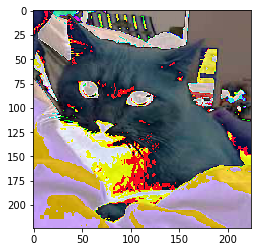

In [80]:
plot(img[0])

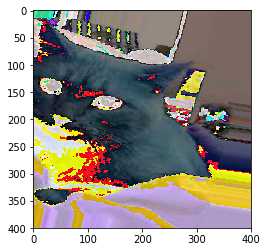

In [84]:
l_img,l_label = l_train_batches.next()
plot(l_img[0])

The reason why this larger image model may not have worked as well is because of the distortion that has been introduced while trying to upscale the image. The 224 x 224 image looks normal even to the human eye whereas the 400 x 400 image looks quite distorted.

NOTE : Of the images appear somewhat strange, its because while loading the batches using ImageDataGenerator, we are first using the ResNet50 'preprocess_input' method which, as indicated by the name' pre-processes the images in resnet50 style